The purpose of this notebook is to get the head position and direction of the ferret for each stimulus presentation.

The input data consists of two sources:
(1) Stimulus metadata after temporal alignment to both video and neural recording systems
(2) LED tracking data

In [99]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
data_dir = Path('/home/stephen/Github/Speaker_Grid/data/F1901_Crumble_Squid/2021-05-27_Squid_15-57')

stim_file = '2021-05-27T17-57-07_StimData_MCSVidAlign.csv'
tracking_file = '2021-05-27_CorrectedVid_17_56_08.csv'

stim = pd.read_csv( str(data_dir / stim_file))

print(stim.shape)

LEDs = pd.read_csv( str(data_dir / tracking_file))

print(LEDs.shape)

(829, 10)
(2487, 15)


In [5]:
join_data = pd.merge( stim, LEDs[['frame','blue_x','red_x','blue_y','red_y']], left_on='closest_frame', right_on='frame')

print(join_data.shape)

(829, 15)


In [6]:
join_data.head(n=4)

,Global_Idx,Block,Local_Idx,Speaker,Pulse_Samp,Pulse_Time,EstimatedTimeOut,MCS_Time,est_frame_time,closest_frame,frame,blue_x,red_x,blue_y,red_y
0,1,0,1,8,61449,1.393401,2.642401,57.41070,47.22070,1181,1181,302.481718,312.388800,141.270774,291.379339
1,2,0,2,40,86358,1.958231,3.207231,57.97550,47.78550,1195,1195,303.181645,312.626964,138.302977,142.563962
2,3,0,3,44,119022,2.698912,3.947912,58.71620,48.52620,1213,1213,302.952116,312.775950,138.722227,289.685129
3,4,0,4,9,146112,3.313197,4.562197,59.42335,49.23335,1231,1231,301.576072,312.738004,142.707884,288.988365


### Tracking data: Problematic positions

We know that when the LEDs go out of view, the tracking code returns ridiculous values. Here we replace anything that isn't sensible with nans.

Note that y values tend to be reasonable even when x values are not (e.g. x=2703, y=123, for a 640x480 image) and so we stop the calculation using the nan on the x value.

In [7]:
join_data.loc[join_data['blue_x'] < 150, 'blue_x'] = np.nan
join_data.loc[join_data['blue_x'] > 500, 'blue_x'] = np.nan
join_data.loc[join_data['blue_y'] < 0, 'blue_y'] = np.nan
join_data.loc[join_data['blue_y'] > 480, 'blue_y'] = np.nan

join_data.loc[join_data['red_x'] < 150, 'red_x'] = np.nan
join_data.loc[join_data['red_x'] > 500, 'red_x'] = np.nan
join_data.loc[join_data['red_y'] < 0, 'red_x'] = np.nan
join_data.loc[join_data['red_y'] > 480, 'red_x'] = np.nan


Calculate head position as center between red and blue LEDs - this is limited because of the poor detection of the red LED and could be improved using only the signal from the blue LED, but since we care most about head direction and need both LEDs to calculate head angle, we'll stick with it

In [9]:
join_data['head_x'] = (join_data['blue_x'] + join_data['red_x']) / 2
join_data['head_y'] = (join_data['blue_y'] + join_data['red_y']) / 2

# Show some examples to get a feel for the data
join_data.head(n=5)


,Global_Idx,Block,Local_Idx,Speaker,Pulse_Samp,Pulse_Time,EstimatedTimeOut,MCS_Time,est_frame_time,closest_frame,frame,blue_x,red_x,blue_y,red_y,head_x,head_y
0,1,0,1,8,61449,1.393401,2.642401,57.41070,47.22070,1181,1181,302.481718,312.388800,141.270774,291.379339,307.435259,216.325056
1,2,0,2,40,86358,1.958231,3.207231,57.97550,47.78550,1195,1195,303.181645,312.626964,138.302977,142.563962,307.904304,140.433469
2,3,0,3,44,119022,2.698912,3.947912,58.71620,48.52620,1213,1213,302.952116,312.775950,138.722227,289.685129,307.864033,214.203678
3,4,0,4,9,146112,3.313197,4.562197,59.42335,49.23335,1231,1231,301.576072,312.738004,142.707884,288.988365,307.157038,215.848125
4,5,0,5,44,166417,3.773628,5.022628,59.88380,49.69380,1242,1242,302.562917,NaN,141.266548,285.872529,NaN,213.569539


Get head direction - here we're assuming that the red LED is on the right side of the head, and the blue LED is on the left side, such that the vector between them represents that interaural axis. In reality, there is a slight rotation in the vector that offsets it from the interaural axis, but we're ignoring that to develop the analysis quickly (and the 2D solution to this problem is inherantly bad anyway)

# TO DO

### Head Stim Angles

Something we need to add is the relationship between the head location and stimulus location. However this requires a bit more information than we currently have, because stimulus locations are known in the real world (e.g. in measurements in cm relative to the grid) whereas LED positions are known only in terms of their position relative to the camera, in pixel values. 

We therefore need some form of calibration, either by mapping LED positions into the world (using some knowledge about the distance of grid features in the image), or by knowing the pixel positions of speakers. I'm going to map the centre positions of each speaker location to make the 

In [120]:
# Compute head angle in the arena
join_data['blue_zero_x'] = join_data['blue_x'] - join_data['head_x']
join_data['blue_zero_y'] = join_data['blue_y'] - join_data['head_y']

offset = -(np.pi/2)
join_data['head_angle'] = np.arctan2(join_data['blue_zero_y'], join_data['blue_zero_x']) + offset

# <==== Need to add wrap to +/- pi here

join_data.dropna(inplace=True)
join_data.reset_index(inplace=True)

ValueError: cannot insert level_0, already exists

In [93]:
join_data.head(n=2)

,Global_Idx,Block,Local_Idx,Speaker,Pulse_Samp,Pulse_Time,EstimatedTimeOut,MCS_Time,est_frame_time,closest_frame,frame,blue_x,red_x,blue_y,red_y,head_x,head_y,blue_zero_x,blue_zero_y,head_angle
0,1,0,1,8,61449,1.393401,2.642401,57.4107,47.2207,1181,1181,302.481718,312.388800,141.270774,291.379339,307.435259,216.325056,-4.953541,-75.054283,-1.636700
1,2,0,2,40,86358,1.958231,3.207231,57.9755,47.7855,1195,1195,303.181645,312.626964,138.302977,142.563962,307.904304,140.433469,-4.722659,-2.130493,-2.717807


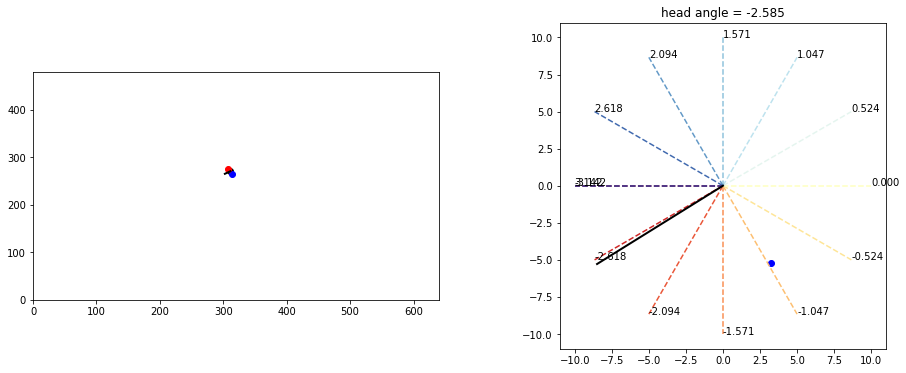

In [119]:
# Draw an example
idx = 100

plt.rcParams['figure.figsize'] = [16, 6]
fig, axs = plt.subplots(1,2)

# Plot positions in image
axs[0].scatter(join_data['head_x'][idx], join_data['head_y'][idx],c='k')
axs[0].scatter(join_data['blue_x'][idx], join_data['blue_y'][idx],c='b')
axs[0].scatter(join_data['red_x'][idx], join_data['red_y'][idx],c='r')

axs[0].set_xlim(0, 640)
axs[0].set_ylim(0, 480)
axs[0].set_aspect(480/640)

# Plot positions relative to head, with polar grid lines
axs[1].scatter(join_data['blue_zero_x'][idx], join_data['blue_zero_y'][idx],c='b')

rho = 10
cmap = cm.get_cmap('RdYlBu')
for phi in np.linspace(-np.pi, np.pi, 13):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    c = (phi + np.pi) / (2 * np.pi)

    axs[1].plot([0, x], [0, y], c=cmap(c), linestyle='--')
    axs[1].text(x, y, f'{phi:.3f}')
    
x = rho * np.cos(join_data['head_angle'][idx])  
y = rho * np.sin(join_data['head_angle'][idx])  

axs[0].plot([0, x]+join_data['head_x'][idx], [0, y]+join_data['head_y'][idx], c='k', linewidth=2)
axs[1].plot([0, x], [0, y], c='k', linewidth=2)

axs[1].set_aspect('equal')
axs[1].set_title(f'head angle = {join_data.head_angle[idx]:.3f}')
plt.show()

In [75]:
# Load speaker positions
speaker_layout = '/home/stephen/Github/Speaker_Grid/metadata/Speaker_grid_layout_2021_05_21.csv'

spk = pd.read_csv(speaker_layout)
spk = spk[['matlab_chan','2021_05_31_PixLoc_Corrected_x','2021_05_31_PixLoc_Corrected_y']]

spk.dropna(inplace=True)
spk.rename(columns={'matlab_chan':'Speaker','2021_05_31_PixLoc_Corrected_x':'speak_xpix','2021_05_31_PixLoc_Corrected_y':'speak_ypix'}, inplace=True)

# Merge with stimulus data
hs_data =  pd.merge(join_data, spk, on='Speaker')


Now we get the vector from head to stimulus (h2s = "head to stimulus" or "head to speaker")

In [76]:
hs_data['h2s_x'] = hs_data['speak_xpix'] - hs_data['head_x']
hs_data['h2s_y'] = hs_data['speak_ypix'] - hs_data['head_y']

Index(['Global_Idx', 'Block', 'Local_Idx', 'Speaker', 'Pulse_Samp',
       'Pulse_Time', 'EstimatedTimeOut', 'MCS_Time', 'est_frame_time',
       'closest_frame', 'frame', 'blue_x', 'red_x', 'blue_y', 'red_y',
       'head_x', 'head_y', 'speak_xpix', 'speak_ypix'],
      dtype='object')

## Visualization

### Fig. 1(A) - Annotated Frame

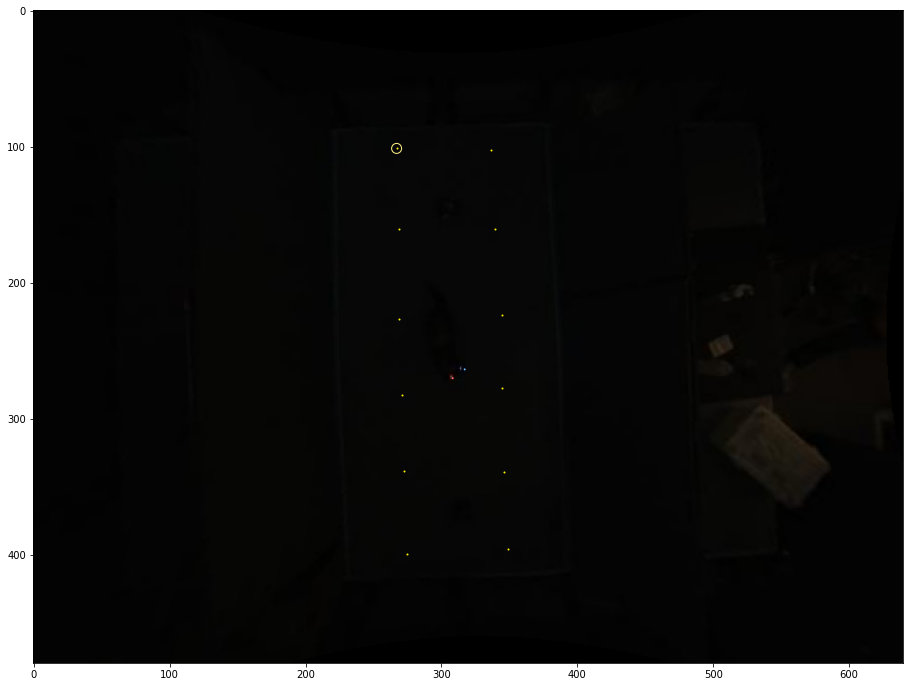

In [63]:
sample_frame = 4405
plt.rcParams['figure.figsize'] = [16, 12]

# Corrected frame
im_path = Path('/home/stephen/Github/Speaker_Grid/data/F1901_Crumble_Squid/2021-05-27_Squid_15-57/example_images_corrected/')
im_file = f"frame{sample_frame:06d}.png"

img = mpimg.imread(str(im_path / im_file))
imgplot = plt.imshow(img)

# LED positions obtained from corrected image
sample_data = join_data[join_data['closest_frame'] == sample_frame]
plt.scatter(sample_data['blue_x'],sample_data['blue_y'], s=1, edgecolors='#6FBAFC', facecolors='none')
plt.scatter(sample_data['red_x'],sample_data['red_y'], s=1, edgecolors='#FC6F6F', facecolors='none')

# Speaker positions from corrected image
speaker_layout = '/home/stephen/Github/Speaker_Grid/metadata/Speaker_grid_layout_2021_05_21.csv'

spk = pd.read_csv(speaker_layout)
spk.dropna(inplace=True)

plt.scatter(spk['2021_05_31_PixLoc_Corrected_x'],spk['2021_05_31_PixLoc_Corrected_y'],c='#FFF300', s=1)

# Label Speaker being played
active_speaker = pd.merge(sample_data, spk, left_on='Speaker', right_on='matlab_chan')

plt.scatter(active_speaker['2021_05_31_PixLoc_Corrected_x'], active_speaker['2021_05_31_PixLoc_Corrected_y'], edgecolors='#FFF388', s=100, facecolors='none')

(223.585399505549, 310.047355306713)

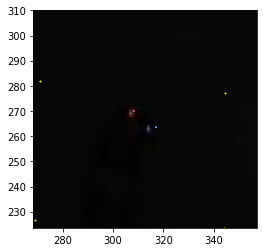

In [54]:
plt_window = (-40, 40)

# # Filter image with laplacian to make features visible
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray,(3,3),0)
# laplacian = cv2.Laplacian(gray, cv2.CV_64F)


# Replot everything from above, but with the intention of zooming in
zoom_plt = plt.imshow(img)
plt.scatter(sample_data['blue_x'],sample_data['blue_y'], s=1, edgecolors='#6FBAFC', facecolors='none')
plt.scatter(sample_data['red_x'],sample_data['red_y'], s=1, edgecolors='#FC6F6F', facecolors='none')
plt.scatter(spk['2021_05_31_PixLoc_Corrected_x'],spk['2021_05_31_PixLoc_Corrected_y'],c='#FFF300', s=1)

x_min = sample_data[['blue_x', 'red_x']].to_numpy().min() + plt_window[0]
x_max = sample_data[['blue_x', 'red_x']].to_numpy().max() + plt_window[1]
y_min = sample_data[['blue_y', 'red_y']].to_numpy().min() + plt_window[0]
y_max = sample_data[['blue_y', 'red_y']].to_numpy().max() + plt_window[1]

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


In [56]:


active_speaker


,Global_Idx,Block,Local_Idx,Speaker,Pulse_Samp,Pulse_Time,EstimatedTimeOut,MCS_Time,est_frame_time,closest_frame,...,Grid_y,Grid_x_cm,Grid_y_cm,Motu_Device,Motu_Channel,Amp,Zone,Channel,2021_05_31_PixLoc_Corrected_x,2021_05_31_PixLoc_Corrected_y
0,174,2,8,29,236541,5.363741,131.675741,186.3976,176.2076,4405,...,40,177.5,197.5,2,5,1,7,1,267.0,101.0
